In [1]:
#wrangle the data
import pandas as pd
import numpy as np
import time

#see the data
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

#play with words
import nltk.sentiment
import nltk
import re
from pprint import pprint

#split and model
from scipy.stats import f_oneway
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import ToktokTokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#import 
from sklearn.feature_extraction.text import CountVectorizer

#sql creds
import env as e
import acquire as a
#scraping
import requests
from bs4 import BeautifulSoup

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from env import github_token, github_username

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

from pprint import pprint
from urllib.parse import urljoin

start_page = 1
end_page = 50
base_url = "https://github.com/search?o=desc&q=stars:%3E1&s=forks&type=Repositories"
links = []

# Iterate over each page
for page in range(start_page, end_page + 1):
    url = f"{base_url}&p={page}"
    headers = {"User-Agent": "Chrome/91.0.4472.124"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    repo_items = soup.find_all('li', class_='repo-list-item')
    
    for link in repo_items:
        relative_url = link.a.attrs['href']
        relative_url = relative_url.lstrip('/')  # Remove leading forward slash
        links.append(relative_url)

    # Add a time delay of 1 second
    time.sleep(2)
    
# Print all the links
for link in links:
    pprint(link)
    print()


len(links)

links

In [2]:
df = pd.read_json('data2.json')
df.head()

repo          language  \
0                      octocat/Spoon-Knife              HTML   
1                         github/gitignore              None   
2  Pierian-Data/Complete-Python-3-Bootcamp  Jupyter Notebook   
3                           twbs/bootstrap        JavaScript   
4                  rdpeng/ExData_Plotting1              None   

                                     readme_contents  
0  ### Well hello there!\n\nThis repository is me...  
1  # A collection of `.gitignore` templates\n\nTh...  
2  # Complete-Python-3-Bootcamp\nCourse Files for...  
3  <p align="center">\n  <a href="https://getboot...  
4  ## Introduction\n\nThis assignment uses data f...

In [3]:
df.language.value_counts()

JavaScript          36
Python              16
HTML                15
Java                14
TypeScript          14
Jupyter Notebook    14
Go                   7
C                    6
Ruby                 5
CSS                  4
C++                  3
Shell                3
C#                   3
Rust                 2
Vue                  2
Dockerfile           2
SCSS                 2
Kotlin               2
PHP                  2
Objective-C          2
Starlark             1
Markdown             1
CoffeeScript         1
Dart                 1
TeX                  1
Name: language, dtype: int64

In [4]:
def tokenize(text):
    """
    Tokenizes the words in the input string.
    """
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

In [5]:
def clean(text: str) -> list: 
    """A simple function to cleanup text data"""
    
    #remove non-ascii characters & lower
    text = (text.encode('ascii', 'ignore')
                .decode('utf-8', 'ignore')
                .lower())
    
    #remove special characters
    words = re.sub(r'[^\w\s]', ' ', text).split()
    
    #build the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #getting all stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
#clean data
df['clean_contents'] = df.readme_contents.apply(tokenize).apply(' '.join)
df['clean_contents'] = df.clean_contents.apply(clean).apply(' '.join)

In [7]:
# words to remove
words_to_remove = ["http", "com", "124","www","1","github","top","go","android","content","table","107","markdown"]

# Iterate over each word in the 'words_to_remove' list
for word in words_to_remove:
    df['clean_contents'] = df['clean_contents'].str.replace(word, '')

In [8]:
# create nltk.sentiment.SentimentIntensityAnalyser()
# use polarity_scores from that object

sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [9]:
#apply to dataframe
df['sentiment'] = df['clean_contents'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
df.head()

repo          language  \
0                      octocat/Spoon-Knife              HTML   
1                         github/gitignore              None   
2  Pierian-Data/Complete-Python-3-Bootcamp  Jupyter Notebook   
3                           twbs/bootstrap        JavaScript   
4                  rdpeng/ExData_Plotting1              None   

                                     readme_contents  \
0  ### Well hello there!\n\nThis repository is me...   
1  # A collection of `.gitignore` templates\n\nTh...   
2  # Complete-Python-3-Bootcamp\nCourse Files for...   
3  <p align="center">\n  <a href="https://getboot...   
4  ## Introduction\n\nThis assignment uses data f...   

                                      clean_contents  sentiment  
0  well hello repository meant provide example fo...     0.9371  
1  collection gitignore template  collection giti...     0.9991  
2  plete python 3 bootcamp course file plete pyth...     0.4404  
3  p align center href  getbootstrap  img src  ge...     0.9943  
4  introduction assignment us data href  archive ...     0.9903

In [10]:
# add two new columns 'message_length' and 'word_count'

df['message_length'] = df['clean_contents'].str.len()
# we apply our clean function, apply len chained on it

# if we did not want to clean this before word count, we would want to do a split on it

df['word_count'] = df.clean_contents.apply(clean).apply(len)

In [11]:
#call top 5 languages to keep and assign all others to other
languages_to_keep = ['JavaScript', 'Python', 'Java', 'TypeScript', 'HTML']
df['language'] = np.where(df['language'].isin(languages_to_keep), df['language'], 'Other')

In [12]:
#check it out
df.head()

repo    language  \
0                      octocat/Spoon-Knife        HTML   
1                         github/gitignore       Other   
2  Pierian-Data/Complete-Python-3-Bootcamp       Other   
3                           twbs/bootstrap  JavaScript   
4                  rdpeng/ExData_Plotting1       Other   

                                     readme_contents  \
0  ### Well hello there!\n\nThis repository is me...   
1  # A collection of `.gitignore` templates\n\nTh...   
2  # Complete-Python-3-Bootcamp\nCourse Files for...   
3  <p align="center">\n  <a href="https://getboot...   
4  ## Introduction\n\nThis assignment uses data f...   

                                      clean_contents  sentiment  \
0  well hello repository meant provide example fo...     0.9371   
1  collection gitignore template  collection giti...     0.9991   
2  plete python 3 bootcamp course file plete pyth...     0.4404   
3  p align center href  getbootstrap  img src  ge...     0.9943   
4  introduction assignment us data href  archive ...     0.9903   

   message_length  word_count  
0             491          65  
1            4532         615  
2             167          26  
3            9552        1356  
4            2953         465

<AxesSubplot:>

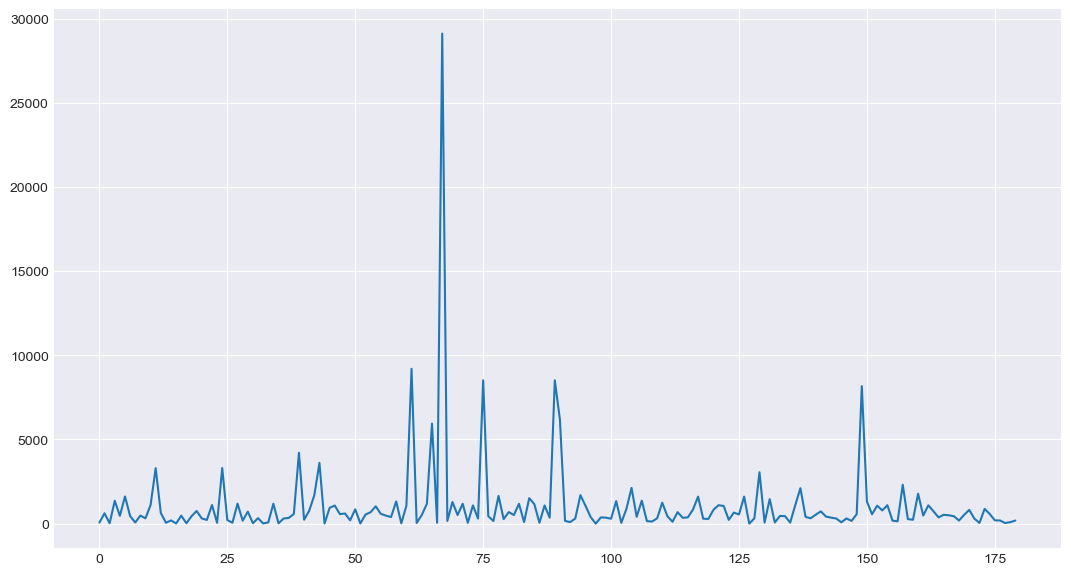

In [13]:
df.word_count.plot()

<AxesSubplot:>

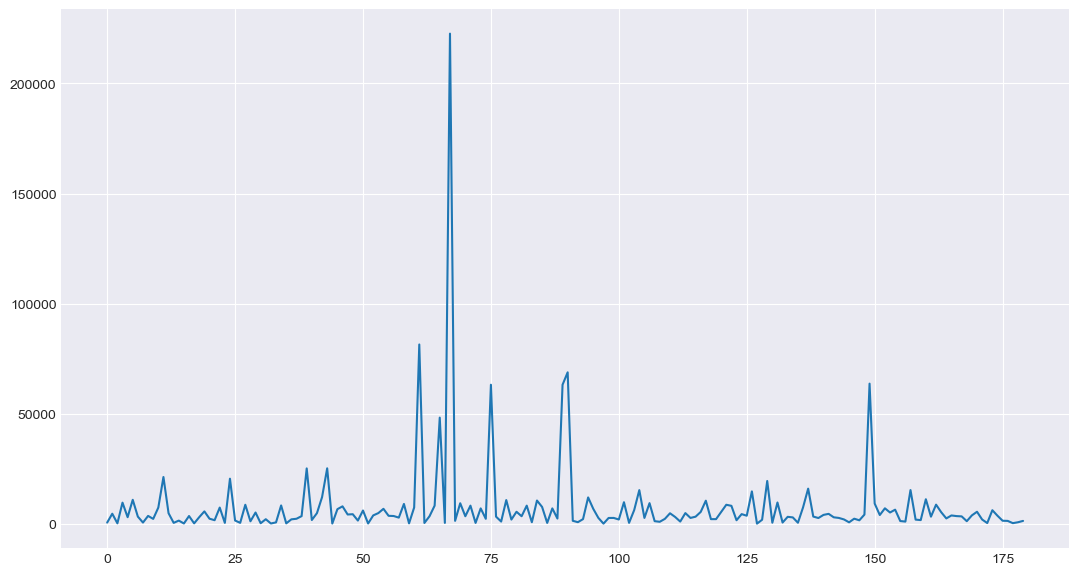

In [14]:
df.message_length.plot()

In [15]:
# Filter the DataFrame based on conditions for word_count and message_length
df = df.loc[(df['word_count'] <= 10000) & (df['message_length'] <= 60000)]

<AxesSubplot:>

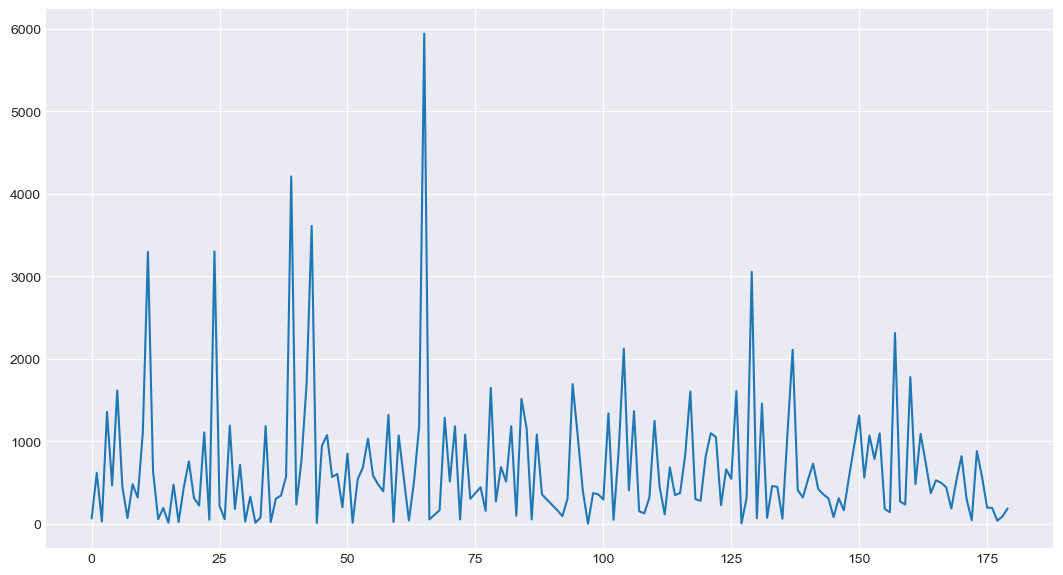

In [16]:
df.word_count.plot()

<AxesSubplot:>

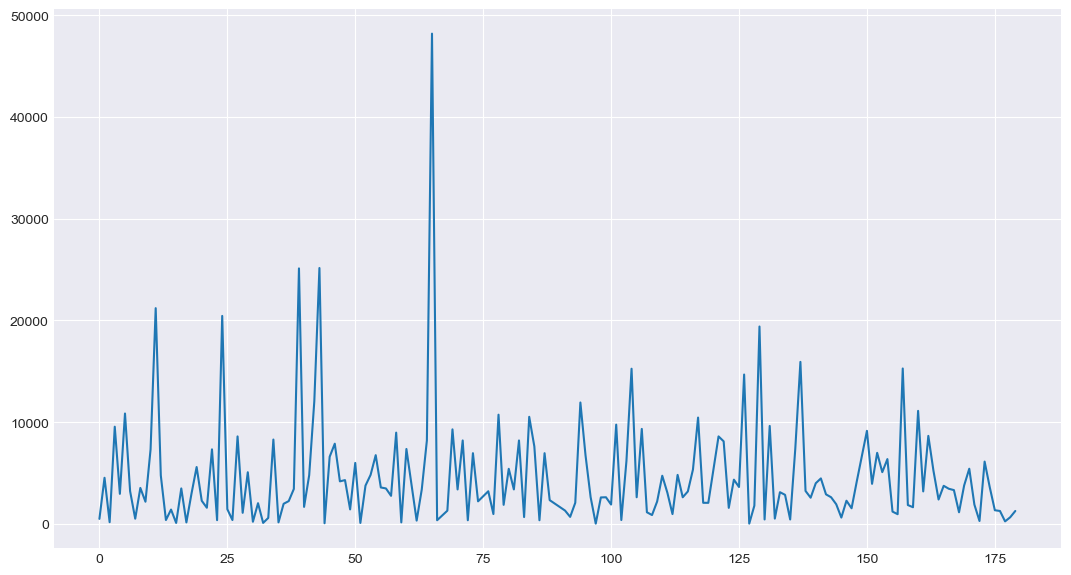

In [17]:
df.message_length.plot()

In [18]:
df.language.value_counts().sum()

174

In [19]:
#baseline (other/all)
68/160

0.425

# Exploration

In [20]:
def split_data(df, variable):
    '''
    take in a DataFrame and target variable. return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.20, random_state=123, stratify=df[variable])
    
    train, validate = train_test_split(train_validate, 
                                       test_size=.25, 
                                       random_state=123,
                                      stratify = train_validate[variable])
    return train, validate, test

In [21]:
train, validate, test = split_data(df, 'language')
train.head()

repo    language  \
73                    rust-lang/rust       Other   
15              soyHenry/Prep-Course  JavaScript   
31       rafaballerini/rafaballerini       Other   
62            Homebrew/homebrew-core       Other   
115  bradtraversy/vanillawebprojects  JavaScript   

                                       readme_contents  \
73   # The Rust Programming Language\n\n[![Rust Com...   
15   {\n  "lessonTitle": "Introducción",\n  "permal...   
31   ## Oiii eu sou a Rafaella Ballerini, criadora ...   
62   # Homebrew Core\n\nCore formulae for the Homeb...   
115  # 20+ Web Projects With Vanilla JavaScript\n\n...   

                                        clean_contents  sentiment  \
73   rust programming language rust munity  img shi...     0.9944   
15   lessontitle introduccin permalink index html l...     0.0000   
31   oiii eu sou rafaella ballerini criadora de con...     0.5574   
62   homebrew core core formula homebrew package ma...     0.4767   
115  20 web project vanilla javascript main reposit...     0.9442   

     message_length  word_count  
73             6950        1081  
15               94          12  
31             2035         328  
62              324          39  
115            3189         372

- separate specific words by language category

In [22]:
# we can do that process with a join on a Series and not just a list
# we will do that all words and categories
# we will pass our basic cleaning on top of that

JavaScript_words = clean(' '.join(train[train.language=='JavaScript']['clean_contents']))
Python_words = clean(' '.join(train[train.language=='Python']['clean_contents']))
Java_words = clean(' '.join(train[train.language=='Java']['clean_contents']))
TypeScript_words = clean(' '.join(train[train.language=='TypeScript']['clean_contents']))
HTML_words = clean(' '.join(train[train.language=='HTML']['clean_contents']))
Other_words = clean(' '.join(train[train.language=='Other']['clean_contents']))
all_words = clean(' '.join(train['clean_contents']))

In [23]:
#check it out
JavaScript_words

['lessontitle',
 'introduccin',
 'permalink',
 'index',
 'html',
 'layout',
 'intro',
 'eleventynavigation',
 'key',
 'intro',
 'order',
 '0',
 '20',
 'web',
 'project',
 'vanilla',
 'javascript',
 'main',
 'repository',
 'project',
 'course',
 'course',
 'link',
 'udemy',
 'course',
 'web',
 'project',
 'vanilla',
 'javascript',
 'referralcode',
 'f9b7c7fed834f9ade75',
 'course',
 'info',
 'website',
 'vanillawebprojects',
 'project',
 'live',
 'demo',
 '0',
 'form',
 'validator',
 'bradtraversy',
 'vanillawebprojects',
 'tree',
 'master',
 'form',
 'validator',
 'live',
 'demo',
 'vanillawebprojects',
 'project',
 'form',
 'validator',
 '02',
 'movie',
 'seat',
 'booking',
 'bradtraversy',
 'vanillawebprojects',
 'tree',
 'master',
 'movie',
 'seat',
 'booking',
 'live',
 'demo',
 'vanillawebprojects',
 'project',
 'movie',
 'seat',
 'booking',
 '03',
 'custom',
 'video',
 'player',
 'bradtraversy',
 'vanillawebprojects',
 'tree',
 'master',
 'custom',
 'video',
 'player',
 'live',
 

In [24]:
#check it out
Python_words

['diffusion',
 'web',
 'ui',
 'browser',
 'interface',
 'based',
 'gradio',
 'library',
 'diffusion',
 'screenshot',
 'png',
 'feature',
 'detailed',
 'feature',
 'showcase',
 'image',
 'automatic',
 'diffusion',
 'webui',
 'wiki',
 'feature',
 'original',
 'txt2img',
 'img2img',
 'mode',
 'one',
 'click',
 'install',
 'run',
 'script',
 'still',
 'must',
 'install',
 'python',
 'git',
 'outpainting',
 'inpainting',
 'color',
 'sketch',
 'prompt',
 'matrix',
 'diffusion',
 'upscale',
 'attention',
 'specify',
 'part',
 'text',
 'model',
 'pay',
 'attention',
 'man',
 'tuxedo',
 'pay',
 'attention',
 'tuxedo',
 'man',
 'tuxedo',
 '2',
 'alternative',
 'syntax',
 'select',
 'text',
 'press',
 'ctrl',
 'ctrl',
 'mand',
 'mand',
 'macos',
 'automatically',
 'adjust',
 'attention',
 'selected',
 'text',
 'code',
 'contributed',
 'anonymous',
 'user',
 'loopback',
 'run',
 'img2img',
 'processing',
 'multiple',
 'time',
 'x',
 'z',
 'plot',
 'way',
 'draw',
 '3',
 'dimensional',
 'plot',
 'i

In [25]:
#check it out
Java_words

['build',
 'project',
 'netty',
 'netty',
 'workflow',
 'build',
 '20project',
 'badge',
 'svg',
 'netty',
 'project',
 'netty',
 'asynchronous',
 'event',
 'driven',
 'network',
 'application',
 'framework',
 'rapid',
 'development',
 'maintainable',
 'high',
 'performance',
 'protocol',
 'server',
 'amp',
 'client',
 'link',
 'web',
 'site',
 'netty',
 'io',
 'downloads',
 'netty',
 'io',
 'downloads',
 'html',
 'documentation',
 'netty',
 'io',
 'wiki',
 'netty_project',
 'twitter',
 'netty_project',
 'official',
 'discord',
 'server',
 'discord',
 'gg',
 'q4aq2xjaca',
 'build',
 'detailed',
 'information',
 'building',
 'developing',
 'netty',
 'please',
 'visit',
 'developer',
 'guide',
 'netty',
 'io',
 'wiki',
 'developer',
 'guide',
 'html',
 'page',
 'give',
 'basic',
 'information',
 'require',
 'following',
 'build',
 'netty',
 'latest',
 'openjdk',
 '8',
 'adoptium',
 'net',
 'latest',
 'apache',
 'maven',
 'maven',
 'apache',
 'org',
 'linux',
 'macos',
 'need',
 'addition

In [26]:
#check it out
TypeScript_words

['onefraction',
 'platform',
 'began',
 'building',
 'client',
 'signed',
 'began',
 'building',
 'decided',
 'pivot',
 'pay',
 'sometimes',
 'get',
 'screwed',
 'business',
 'least',
 'cool',
 'boilerplate',
 'give',
 'away',
 'onefraction',
 'gif',
 'imgur',
 'ipbldhy',
 'gif',
 'onefraction',
 'supposed',
 'platform',
 'gave',
 'user',
 'reward',
 'paying',
 'rent',
 'platform',
 'opposed',
 'check',
 'bank',
 'transfer',
 'value',
 'would',
 'e',
 'leveraging',
 'data',
 'eventually',
 'create',
 'rental',
 'marketplace',
 'user',
 'find',
 'perfect',
 'apartment',
 'move',
 'stack',
 'client',
 'built',
 'using',
 'react',
 'native',
 'web',
 'really',
 'cool',
 'really',
 'easy',
 'turn',
 'mobile',
 'app',
 'server',
 'written',
 'node',
 'j',
 'server',
 'u',
 'graphql',
 'apollo',
 'server',
 'delivering',
 'data',
 'client',
 'server',
 'typeose',
 'interacting',
 'mon',
 'nice',
 'type',
 'friendly',
 'way',
 'account',
 'set',
 'using',
 'wonderful',
 'account',
 'j',
 'lib

In [27]:
#check it out
HTML_words

['react',
 'ponent',
 'basic',
 'lab',
 'learning',
 'al',
 'write',
 'basic',
 'react',
 'ponent',
 'return',
 'one',
 'react',
 'ponent',
 'another',
 'ponent',
 'instruction',
 'lab',
 'throughout',
 'section',
 'working',
 'building',
 'small',
 'portfolio',
 'site',
 'react',
 'al',
 'first',
 'lesson',
 'get',
 'basic',
 'ponent',
 'app',
 'navbar',
 'home',
 'ponent',
 'returned',
 'app',
 'ponent',
 'done',
 'get',
 'something',
 'like',
 'app',
 'demo',
 'curriculum',
 's3',
 'amazonaws',
 'react',
 'demo',
 'png',
 'lab',
 'rendering',
 'child',
 'ponent',
 'ponent',
 'app',
 'work',
 'done',
 'src',
 'ponent',
 'app',
 'j',
 'rest',
 'file',
 'need',
 'change',
 'set',
 'app',
 'run',
 'browser',
 'run',
 'console',
 'npm',
 'install',
 'npm',
 'start',
 'start',
 'work',
 'getting',
 'app',
 'match',
 'screenshot',
 'open',
 'second',
 'terminal',
 'open',
 'directory',
 'run',
 'npm',
 'test',
 'check',
 'work',
 'deliverable',
 'two',
 'ponent',
 'navbar',
 'home',
 'alre

In [28]:
#check it out
Other_words

['rust',
 'programming',
 'language',
 'rust',
 'munity',
 'img',
 'shield',
 'io',
 'badge',
 'rust_munity',
 '20',
 'join_us',
 'brightgreen',
 'style',
 'plastic',
 'lo',
 'rust',
 'rust',
 'lang',
 'org',
 'munity',
 'main',
 'source',
 'code',
 'repository',
 'rust',
 'contains',
 'piler',
 'standard',
 'library',
 'documentation',
 'rust',
 'rust',
 'lang',
 'org',
 'note',
 'readme',
 '_users_',
 'rather',
 '_contributors_',
 'wish',
 '_contribute_',
 'piler',
 'read',
 'contributing',
 'md',
 'contributing',
 'md',
 'instead',
 'quick',
 'start',
 'read',
 'installation',
 'book',
 'installation',
 'doc',
 'rust',
 'lang',
 'org',
 'book',
 'ch0',
 '0',
 'installation',
 'html',
 'book',
 'doc',
 'rust',
 'lang',
 'org',
 'book',
 'index',
 'html',
 'installing',
 'source',
 'rust',
 'build',
 'system',
 'u',
 'python',
 'script',
 'called',
 'x',
 'py',
 'build',
 'piler',
 'manages',
 'bootstrapping',
 'process',
 'life',
 'root',
 'project',
 'also',
 'u',
 'file',
 'named',

In [29]:
#check it out
all_words

['rust',
 'programming',
 'language',
 'rust',
 'munity',
 'img',
 'shield',
 'io',
 'badge',
 'rust_munity',
 '20',
 'join_us',
 'brightgreen',
 'style',
 'plastic',
 'lo',
 'rust',
 'rust',
 'lang',
 'org',
 'munity',
 'main',
 'source',
 'code',
 'repository',
 'rust',
 'contains',
 'piler',
 'standard',
 'library',
 'documentation',
 'rust',
 'rust',
 'lang',
 'org',
 'note',
 'readme',
 '_users_',
 'rather',
 '_contributors_',
 'wish',
 '_contribute_',
 'piler',
 'read',
 'contributing',
 'md',
 'contributing',
 'md',
 'instead',
 'quick',
 'start',
 'read',
 'installation',
 'book',
 'installation',
 'doc',
 'rust',
 'lang',
 'org',
 'book',
 'ch0',
 '0',
 'installation',
 'html',
 'book',
 'doc',
 'rust',
 'lang',
 'org',
 'book',
 'index',
 'html',
 'installing',
 'source',
 'rust',
 'build',
 'system',
 'u',
 'python',
 'script',
 'called',
 'x',
 'py',
 'build',
 'piler',
 'manages',
 'bootstrapping',
 'process',
 'life',
 'root',
 'project',
 'also',
 'u',
 'file',
 'named',

- get word frequency of language categories

In [30]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

JavaScript_words_freq = pd.Series(JavaScript_words).value_counts()
Python_words_freq = pd.Series(Python_words).value_counts()
Java_words_freq = pd.Series(Java_words).value_counts()
TypeScript_words_freq = pd.Series(TypeScript_words).value_counts()
HTML_words_freq = pd.Series(HTML_words).value_counts()
Other_words_freq = pd.Series(Other_words).value_counts()
all_words_freq = pd.Series(all_words).value_counts()

In [31]:
#check it out
JavaScript_words_freq.head()

j            165
bootstrap    146
project       86
next          86
c             85
dtype: int64

In [32]:
#check it out
Python_words_freq.head()

0        155
9        136
panda    110
doc      101
2         91
dtype: int64

In [33]:
#check it out
Java_words_freq.head()

apache      172
dubbo       138
md          136
readme      136
solution    129
dtype: int64

In [34]:
#check it out
TypeScript_words_freq.head()

chatgpt    88
web        80
code       68
next       63
yidadaa    52
dtype: int64

In [35]:
#check it out
HTML_words_freq.head()

file        22
ponent      20
exercise    18
solution    17
c           16
dtype: int64

In [36]:
#check it out
Other_words_freq.head()

learnopencv    547
code           344
master         325
p              315
md             302
dtype: int64

In [37]:
#check it out
all_words_freq.head()

md             588
learnopencv    547
code           511
doc            441
master         422
dtype: int64

In [38]:

pd.concat([JavaScript_words_freq, Python_words_freq, Java_words_freq, TypeScript_words_freq, HTML_words_freq, Other_words_freq, all_words_freq], axis=1).fillna(0).astype(int)

0  1   2   3   4    5    6
j           165  1   2  12   2   19  201
bootstrap   146  0   0   0   0  148  294
project      86  9  19  34  14   74  236
next         86  2   2  63   1    7  161
c            85  7   7   3  16  192  310
...         ... ..  ..  ..  ..  ...  ...
pekladatel    0  0   0   0   0    1    1
vsledkem      0  0   0   0   0    1    1
vdomosti      0  0   0   0   0    1    1
rozshl        0  0   0   0   0    1    1
zmnn          0  0   0   0   0    1    1

[9362 rows x 7 columns]

In [39]:
# lets combine all 5 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([JavaScript_words_freq, Python_words_freq, Java_words_freq, TypeScript_words_freq, HTML_words_freq, Other_words_freq, all_words_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['JavaScript','Python','Java', 'TypeScript', 'HTML', 'Other','All']

word_counts.head()

JavaScript  Python  Java  TypeScript  HTML  Other  All
j                 165       1     2          12     2     19  201
bootstrap         146       0     0           0     0    148  294
project            86       9    19          34    14     74  236
next               86       2     2          63     1      7  161
c                  85       7     7           3    16    192  310

In [40]:
#sort colums based on all
word_counts.sort_values('All', ascending=False).head(10)

JavaScript  Python  Java  TypeScript  HTML  Other  All
md                   77      41   136          27     5    302  588
learnopencv           0       0     0           0     0    547  547
code                 65      21     9          68     4    344  511
doc                  78     101     6          31     5    220  441
master               47      20    25           5     0    325  422
img                  80      32    36          19     0    236  403
org                  53      82    69          32     4    158  398
p                    46       8     6           8     0    315  383
build                68       3    26          21     3    259  380
html                 55      49    10           9    15    240  378

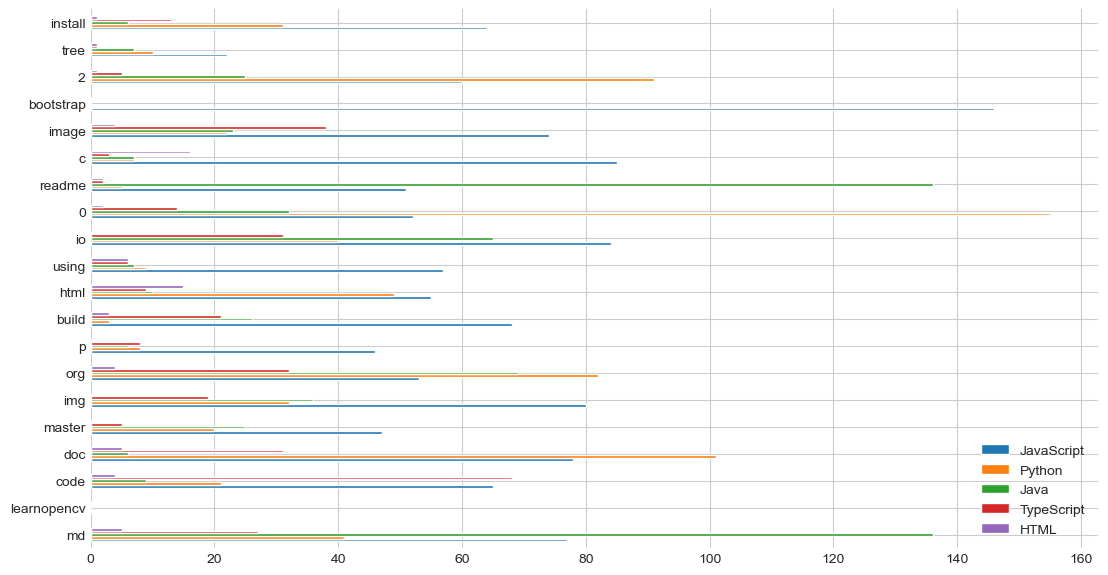

In [74]:
#visualize
word_counts.sort_values('All', ascending=False)[['JavaScript','Python','Java','TypeScript', 'HTML']].head(20).plot.barh()
plt.show()

In [42]:
word_counts.sort_values('All', ascending=False).head(20)\
.apply(lambda row: row/row['All'], axis=1)

JavaScript    Python      Java  TypeScript      HTML     Other  \
md             0.130952  0.069728  0.231293    0.045918  0.008503  0.513605   
learnopencv    0.000000  0.000000  0.000000    0.000000  0.000000  1.000000   
code           0.127202  0.041096  0.017613    0.133072  0.007828  0.673190   
doc            0.176871  0.229025  0.013605    0.070295  0.011338  0.498866   
master         0.111374  0.047393  0.059242    0.011848  0.000000  0.770142   
img            0.198511  0.079404  0.089330    0.047146  0.000000  0.585608   
org            0.133166  0.206030  0.173367    0.080402  0.010050  0.396985   
p              0.120104  0.020888  0.015666    0.020888  0.000000  0.822454   
build          0.178947  0.007895  0.068421    0.055263  0.007895  0.681579   
html           0.145503  0.129630  0.026455    0.023810  0.039683  0.634921   
using          0.160563  0.025352  0.019718    0.016901  0.016901  0.760563   
io             0.237288  0.112994  0.183616    0.087571  0.000000  0.378531   
0              0.148997  0.444126  0.091691    0.040115  0.005731  0.269341   
readme         0.147826  0.014493  0.394203    0.005797  0.005797  0.431884   
c              0.274194  0.022581  0.022581    0.009677  0.051613  0.619355   
image          0.251701  0.074830  0.078231    0.129252  0.013605  0.452381   
bootstrap      0.496599  0.000000  0.000000    0.000000  0.000000  0.503401   
2              0.206186  0.312715  0.085911    0.017182  0.003436  0.374570   
tree           0.080586  0.036630  0.025641    0.003663  0.003663  0.849817   
install        0.244275  0.118321  0.022901    0.049618  0.003817  0.561069   

             All  
md           1.0  
learnopencv  1.0  
code         1.0  
doc          1.0  
master       1.0  
img          1.0  
org          1.0  
p            1.0  
build        1.0  
html         1.0  
using        1.0  
io           1.0  
0            1.0  
readme       1.0  
c            1.0  
image        1.0  
bootstrap    1.0  
2            1.0  
tree         1.0  
install      1.0

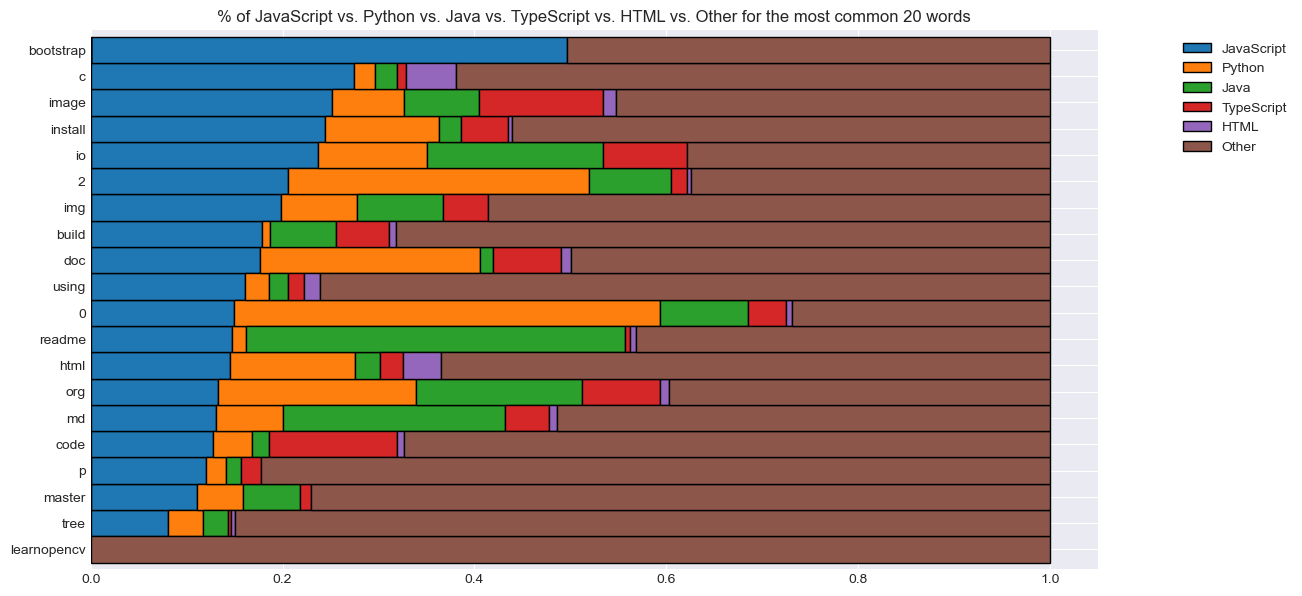

In [43]:
(word_counts.sort_values('All', ascending=False)
.head(20)
.apply(lambda row: row/row['All'], axis = 1)
.drop(columns='All')
.sort_values(by='JavaScript')
.plot.barh(stacked=True, width=1, ec='black')
)

plt.title('% of JavaScript vs. Python vs. Java vs. TypeScript vs. HTML vs. Other for the most common 20 words')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()

# Stats Test

## Is word count significant in identifying language category?

$H_{0}$ : There is no difference in word count as they apply to language category

$H_{a}$ : There is a difference in word count as they apply to language category

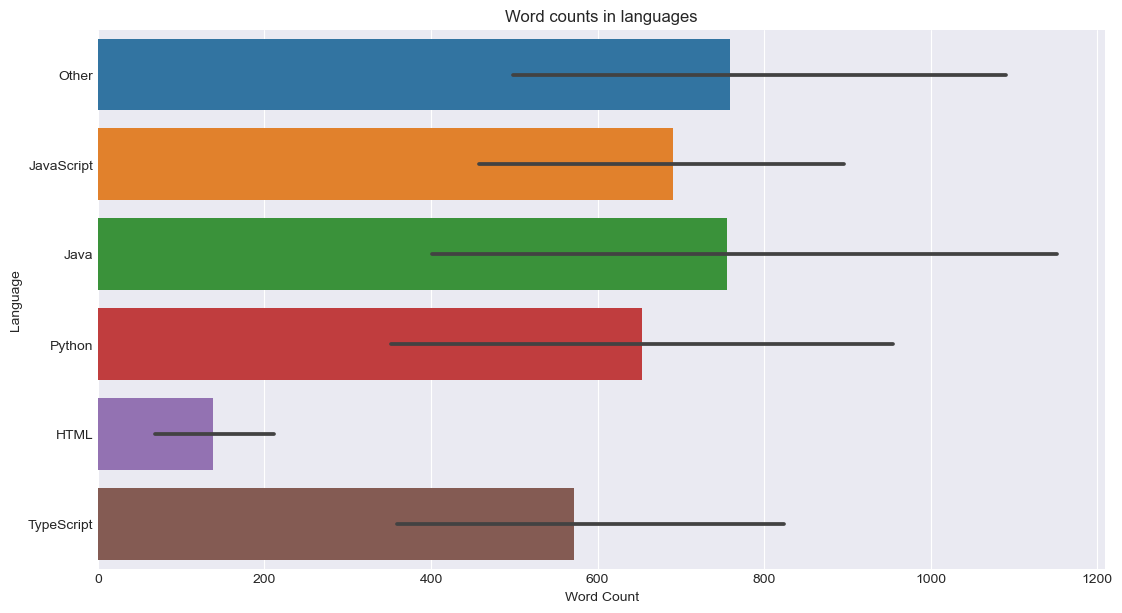

In [44]:
#visualize
sns.barplot(data=train, x='word_count', y='language')
plt.xlabel('Word Count')
plt.ylabel('Language')
plt.title('Word counts in languages')
plt.show()

In [45]:
#set alpha
alpha = 0.05

In [46]:
#check for equal variances
javascript_stats = train[train.language=='JavaScript']['word_count']
python_stats = train[train.language=='Python']['word_count']
java_stats = train[train.language=='Java']['word_count']
typescript_stats = train[train.language=='TypeScript']['word_count']
HTML_stats = train[train.language=='HTML']['word_count']
other_stats = train[train.language=='Other']['word_count']

In [47]:
#run stats test
# Perform the ANOVA test
f_value, p_value = f_oneway(
    javascript_stats,
    python_stats,
    java_stats,
    typescript_stats,
    HTML_stats,
    other_stats
)

# Print the ANOVA test results
print("F-value:", f_value)
print("p-value:", p_value)

F-value: 0.7997059664685812
p-value: 0.552509071127988


-  The p-value of the ANOVA test is greater than alpha so we can infer that the word count doesn't identify language category. Therefore, we fail to reject the null hypothesis.

## Is message length significant in identifying language category?

$H_{0}$ : There is no difference in message length as it applies to language category

$H_{a}$ : There is a difference in message length as it applies to language category

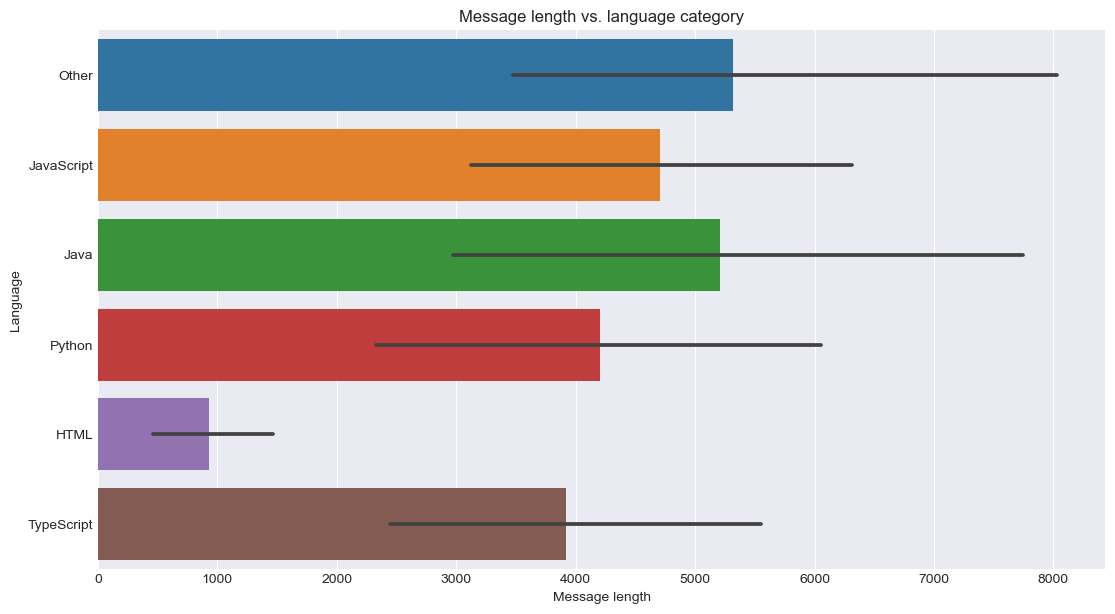

In [48]:
#visualize
sns.barplot(data=train, x='message_length', y='language')
plt.xlabel('Message length')
plt.ylabel('Language')
plt.title('Message length vs. language category')
plt.show()

In [49]:
#check for equal variances
javascript_stats_ml = train[train.language=='JavaScript']['message_length']
python_stats_ml = train[train.language=='Python']['message_length']
java_stats_ml = train[train.language=='Java']['message_length']
typescript_stats_ml = train[train.language=='TypeScript']['message_length']
HTML_stats_ml = train[train.language=='HTML']['message_length']
other_stats_ml = train[train.language=='Other']['message_length']

In [50]:
#run stats test
# Perform the ANOVA test
f_value, p_value = f_oneway(
    javascript_stats_ml,
    python_stats_ml,
    java_stats_ml,
    typescript_stats_ml,
    HTML_stats_ml,
    other_stats_ml
)

# Print the ANOVA test results
print("F-value:", f_value)
print("p-value:", p_value)

F-value: 0.7739573937021451
p-value: 0.5707833189924916


-  The p-value of the ANOVA test is greater than alpha so we can infer that the message length doesn't identify language category. Therefore, we fail to reject the null hypothesis.

# Word Clouds

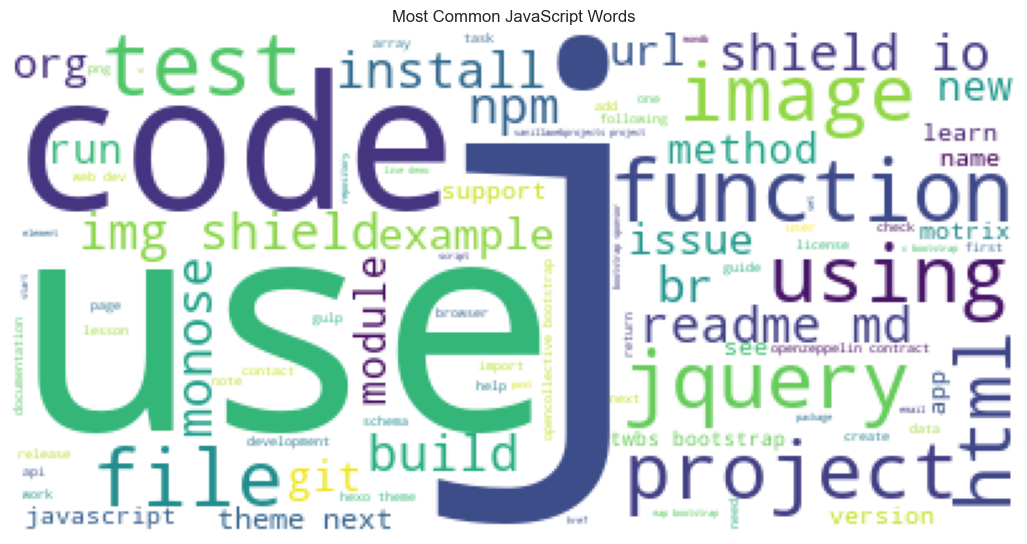

In [51]:
# Javascript word cloud
img = WordCloud(background_color='white').generate(' '.join(JavaScript_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common JavaScript Words')
plt.show()

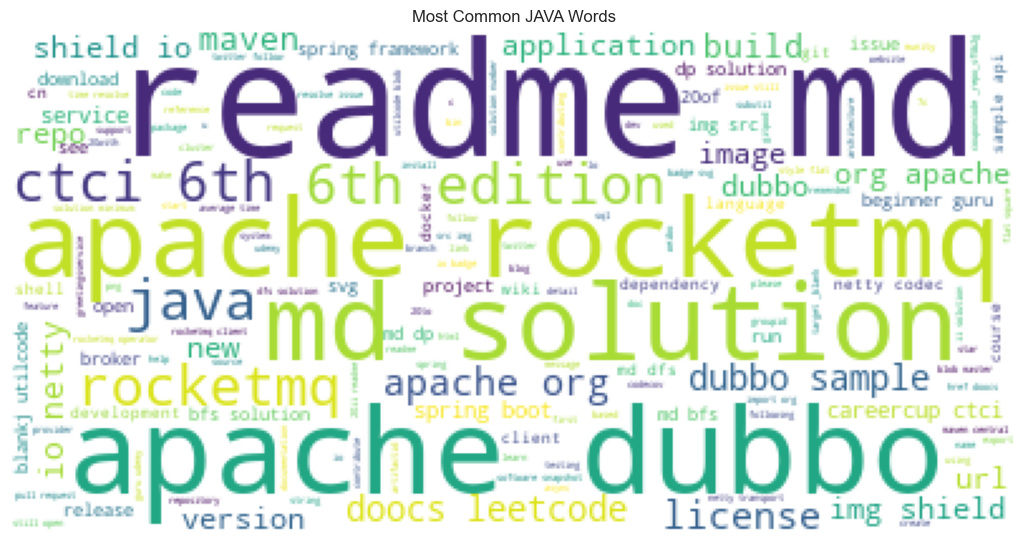

In [52]:
# Java word cloud
img = WordCloud(background_color='white').generate(' '.join(Java_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common JAVA Words')
plt.show()

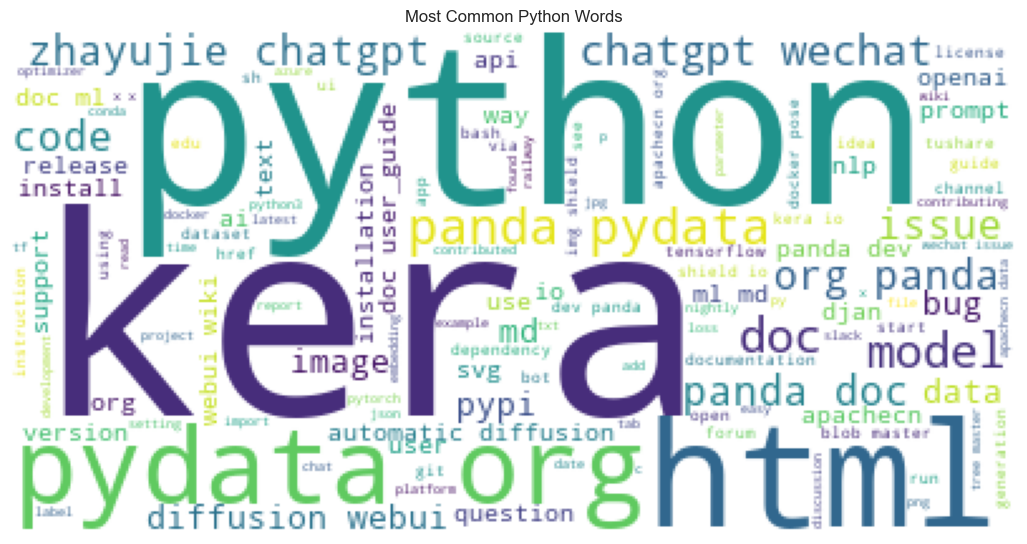

In [53]:
# Python word cloud
img = WordCloud(background_color='white').generate(' '.join(Python_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Python Words')
plt.show()

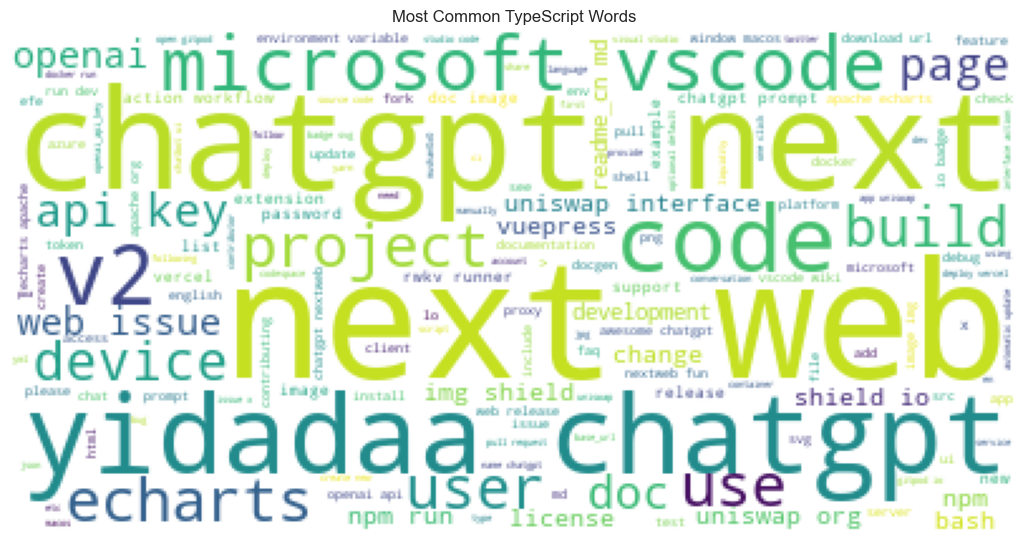

In [54]:
# Python word cloud
img = WordCloud(background_color='white').generate(' '.join(TypeScript_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common TypeScript Words')
plt.show()

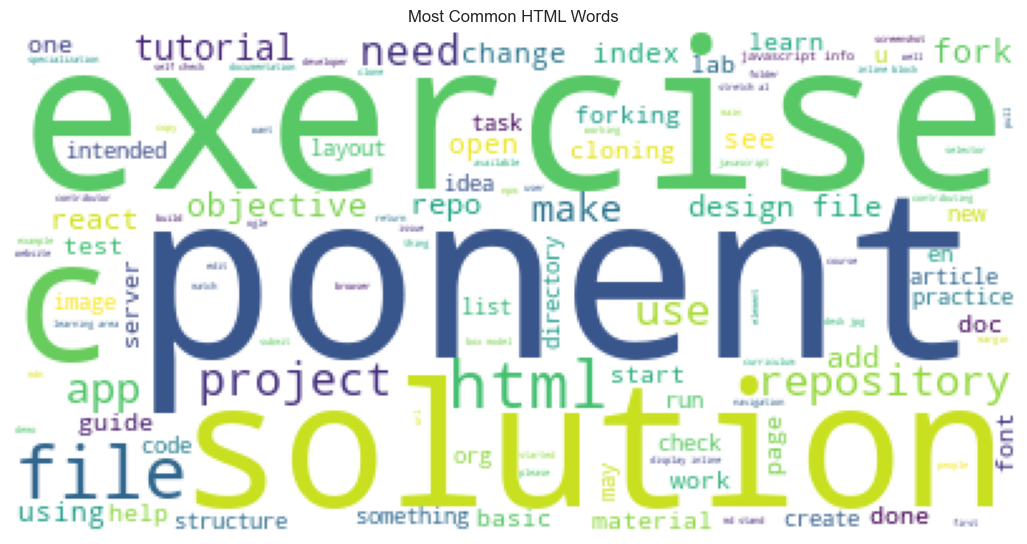

In [55]:
# Python word cloud
img = WordCloud(background_color='white').generate(' '.join(HTML_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common HTML Words')
plt.show()

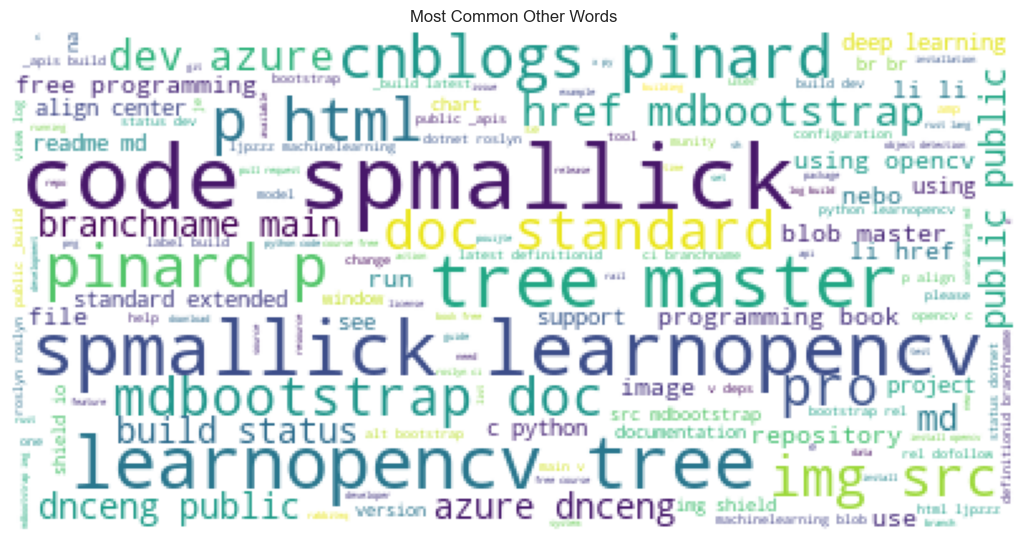

In [56]:
# Other word cloud
img = WordCloud(background_color='white').generate(' '.join(Other_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Other Words')
plt.show()

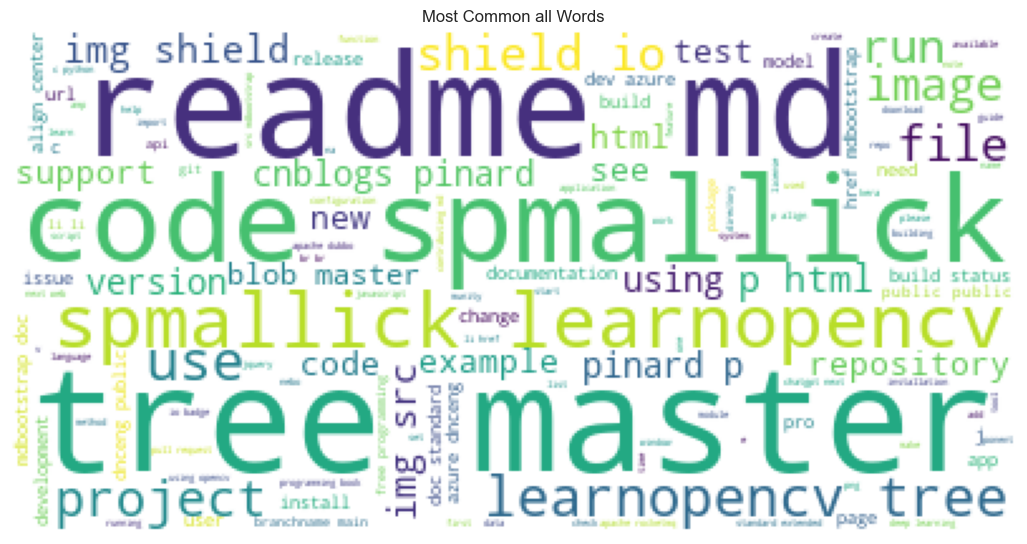

In [57]:
# All word cloud
img = WordCloud(background_color='white').generate(' '.join(all_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common all Words')
plt.show()

# Sentiment analysis

In [58]:
# is the mean and median values of sentiment score different for categories?

train.groupby('language').sentiment.agg(['mean','median'])

mean   median
language                     
HTML        0.649487  0.92355
Java        0.689562  0.99135
JavaScript  0.836352  0.99080
Other       0.753229  0.97760
Python      0.684960  0.91865
TypeScript  0.851513  0.98315

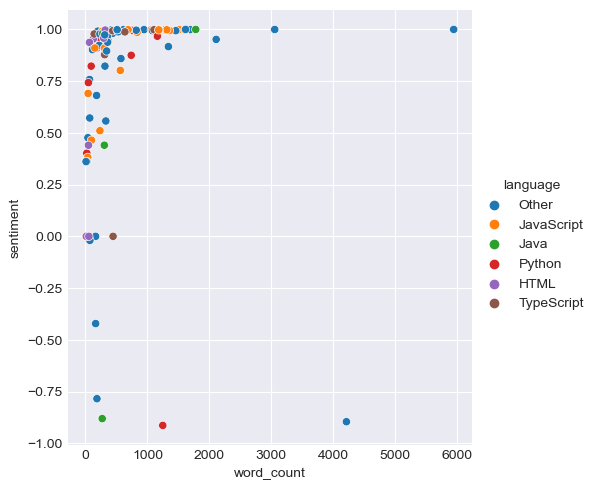

In [59]:
#plot word_count vs sentiment and hue by label

sns.relplot(data=train, x='word_count', y='sentiment', hue='language');

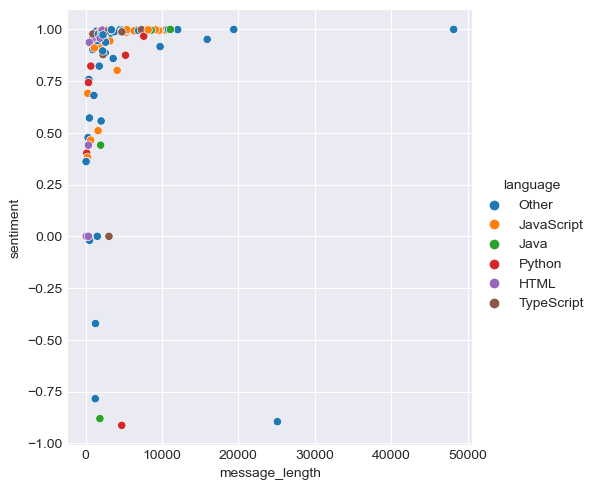

In [60]:
#plot message_length vs sentiment and hue by label

sns.relplot(data=train, x='message_length', y='sentiment', hue='language');

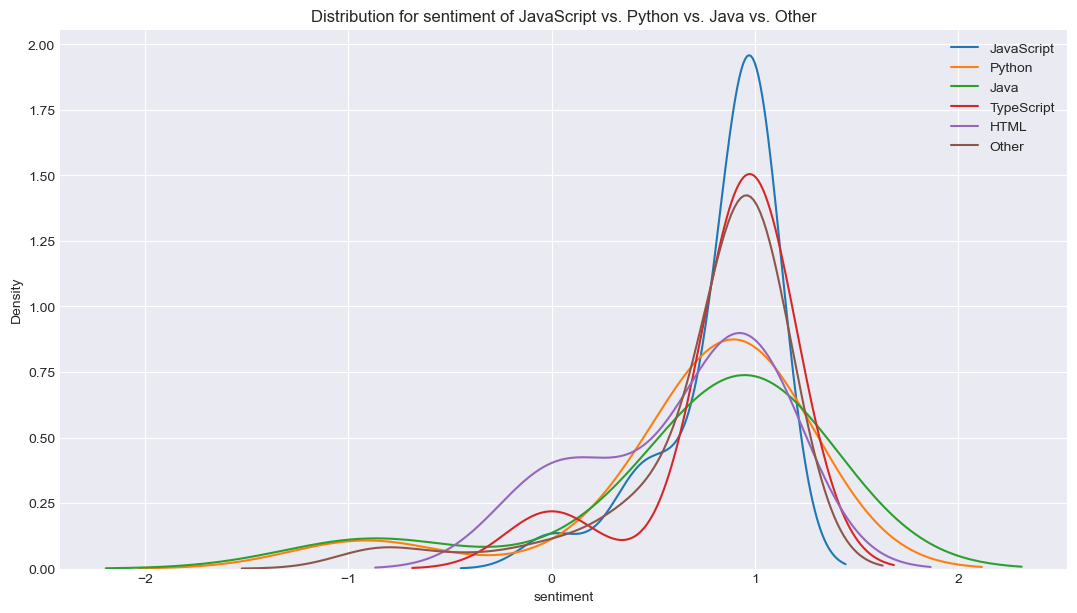

In [61]:
# is the distribution for sentiment 

sns.kdeplot(train[train.language=='JavaScript'].sentiment, label='JavaScript')
sns.kdeplot(train[train.language=='Python'].sentiment, label='Python')
sns.kdeplot(train[train.language=='Java'].sentiment, label='Java')
sns.kdeplot(train[train.language=='TypeScript'].sentiment, label='TypeScript')
sns.kdeplot(train[train.language=='HTML'].sentiment, label='HTML')
sns.kdeplot(train[train.language=='Other'].sentiment, label='Other')


plt.legend()
plt.title("Distribution for sentiment of JavaScript vs. Python vs. Java vs. Other")
plt.show()

# Modeling

- split data into X_train, X_validate, X_test, y_train, y_validate, y_test
    - make 'bag of words' for modeling

In [62]:
train.head()

repo    language  \
73                    rust-lang/rust       Other   
15              soyHenry/Prep-Course  JavaScript   
31       rafaballerini/rafaballerini       Other   
62            Homebrew/homebrew-core       Other   
115  bradtraversy/vanillawebprojects  JavaScript   

                                       readme_contents  \
73   # The Rust Programming Language\n\n[![Rust Com...   
15   {\n  "lessonTitle": "Introducción",\n  "permal...   
31   ## Oiii eu sou a Rafaella Ballerini, criadora ...   
62   # Homebrew Core\n\nCore formulae for the Homeb...   
115  # 20+ Web Projects With Vanilla JavaScript\n\n...   

                                        clean_contents  sentiment  \
73   rust programming language rust munity  img shi...     0.9944   
15   lessontitle introduccin permalink index html l...     0.0000   
31   oiii eu sou rafaella ballerini criadora de con...     0.5574   
62   homebrew core core formula homebrew package ma...     0.4767   
115  20 web project vanilla javascript main reposit...     0.9442   

     message_length  word_count  
73             6950        1081  
15               94          12  
31             2035         328  
62              324          39  
115            3189         372

In [63]:
#make X_train, X_validate, X_test, y_train, y_validate, y_test
X_train = train.clean_contents
X_validate = validate.clean_contents
X_test = test.clean_contents
y_train = train.language
y_validate = validate.language
y_test = test.language

In [64]:
#make my bag of words
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train)
X_validate_bow = cv.transform(X_validate)
X_test_bow = cv.transform(X_test)

In [65]:
X_bow

<104x9346 sparse matrix of type '<class 'numpy.int64'>'
	with 24420 stored elements in Compressed Sparse Row format>

## Decision Tree

In [66]:
def decision_tree(X_bow, X_validate_bow, y_train, y_validate):
    """
    This function trains a decision tree classifier on the provided training data, and evaluates its performance on the
    validation data for different values of the 'max_depth' hyperparameter. It then generates a plot of the training and
    validation accuracy scores as a function of 'max_depth', and returns a DataFrame containing these scores.

    Parameters:
    - X_train (pandas.DataFrame): A DataFrame containing the features for the training data.
    - X_validate (pandas.DataFrame): A DataFrame containing the features for the validation data.
    - y_train (pandas.Series): A Series containing the target variable for the training data.
    - y_validate (pandas.Series): A Series containing the target variable for the validation data.

    Returns:
    - scores_df (pandas.DataFrame): A DataFrame containing the training and validation accuracy scores, as well as the
      difference between them, for different values of the 'max_depth' hyperparameter.
    """
    # get data
    scores_all = []
    for x in range(1,20):
        tree = DecisionTreeClassifier(max_depth=x, random_state=123)
    
        tree.fit(X_bow, y_train)
        train_acc = tree.score(X_bow,y_train)
        val_acc = tree.score(X_validate_bow, y_validate)
        score_diff = train_acc - val_acc
        scores_all.append([x, train_acc, val_acc, score_diff])
    
    scores_df = pd.DataFrame(scores_all, columns=['max_depth', 'train_acc','val_acc','score_diff'])
    
    # Plot the results
    sns.set_style('whitegrid')
    plt.plot(scores_df['max_depth'], scores_df['train_acc'], label='Train score')
    plt.plot(scores_df['max_depth'], scores_df['val_acc'], label='Validation score')
    plt.fill_between(scores_df['max_depth'], scores_df['train_acc'], scores_df['val_acc'], alpha=0.2, color='gray')
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.legend()
    plt.show()

    return scores_df

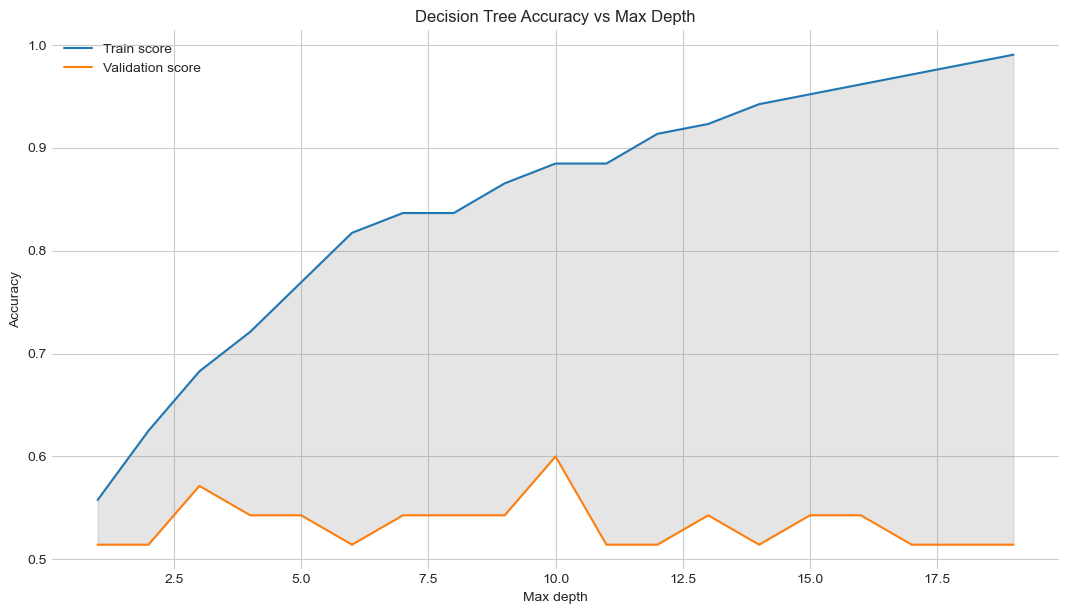

max_depth  train_acc   val_acc  score_diff
0           1   0.557692  0.514286    0.043407
1           2   0.625000  0.514286    0.110714
2           3   0.682692  0.571429    0.111264
3           4   0.721154  0.542857    0.178297
4           5   0.769231  0.542857    0.226374
5           6   0.817308  0.514286    0.303022
6           7   0.836538  0.542857    0.293681
7           8   0.836538  0.542857    0.293681
8           9   0.865385  0.542857    0.322527
9          10   0.884615  0.600000    0.284615
10         11   0.884615  0.514286    0.370330
11         12   0.913462  0.514286    0.399176
12         13   0.923077  0.542857    0.380220
13         14   0.942308  0.514286    0.428022
14         15   0.951923  0.542857    0.409066
15         16   0.961538  0.542857    0.418681
16         17   0.971154  0.514286    0.456868
17         18   0.980769  0.514286    0.466484
18         19   0.990385  0.514286    0.476099

In [67]:
#run the model
decision_tree(X_bow, X_validate_bow, y_train, y_validate)

## Random Forest

In [68]:
def random_forest_scores(X_bow, y_train, X_validate_bow, y_validate):
    """
    Trains and evaluates a random forest classifier with different combinations of hyperparameters. The function takes in 
    training and validation datasets, and returns a dataframe summarizing the model performance on each combination of 
    hyperparameters.

    Parameters:
    -----------
    X_train : pandas DataFrame
        Features of the training dataset.
    y_train : pandas Series
        Target variable of the training dataset.
    X_validate : pandas DataFrame
        Features of the validation dataset.
    y_validate : pandas Series
        Target variable of the validation dataset.

    Returns:
    --------
    df : pandas DataFrame
        A dataframe summarizing the model performance on each combination of hyperparameters.
    """
    #define variables
    train_scores = []
    validate_scores = []
    min_samples_leaf_values = [1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]
    max_depth_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    
    
    for min_samples_leaf, max_depth in zip(min_samples_leaf_values, max_depth_values):
        rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth,random_state=123)
        rf.fit(X_bow, y_train)
        train_score = rf.score(X_bow, y_train)
        validate_score = rf.score(X_validate_bow, y_validate)
        train_scores.append(train_score)
        validate_scores.append(validate_score)
       
    # Calculate the difference between the train and validation scores
    diff_scores = [train_score - validate_score for train_score, validate_score in zip(train_scores, validate_scores)]
    
    #Put results into a dataframe
    df = pd.DataFrame({
        'min_samples_leaf': min_samples_leaf_values,
        'max_depth': max_depth_values,
        'train_score': train_scores,
        'validate_score': validate_scores,
        'diff_score': diff_scores})
     
    # Set plot style
    sns.set_style('whitegrid')
 
    # Create plot
    plt.figure(figsize=(8, 6))
    plt.plot(max_depth_values, train_scores, label='train', marker='o', color='blue')
    plt.plot(max_depth_values, validate_scores, label='validation', marker='o', color='orange')
    plt.fill_between(max_depth_values, train_scores, validate_scores, alpha=0.2, color='gray')
    plt.xticks([2,4,6,8,10],['Leaf 9 and Depth 2','Leaf 7 and Depth 4','Leaf 5 and Depth 6','Leaf 3 and Depth 8','Leaf 1and Depth 10'], rotation = 45)
    plt.xlabel('min_samples_leaf and max_depth', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Random Forest Classifier Performance', fontsize=18)
    plt.legend(fontsize=12)
    plt.show()
    
    return df

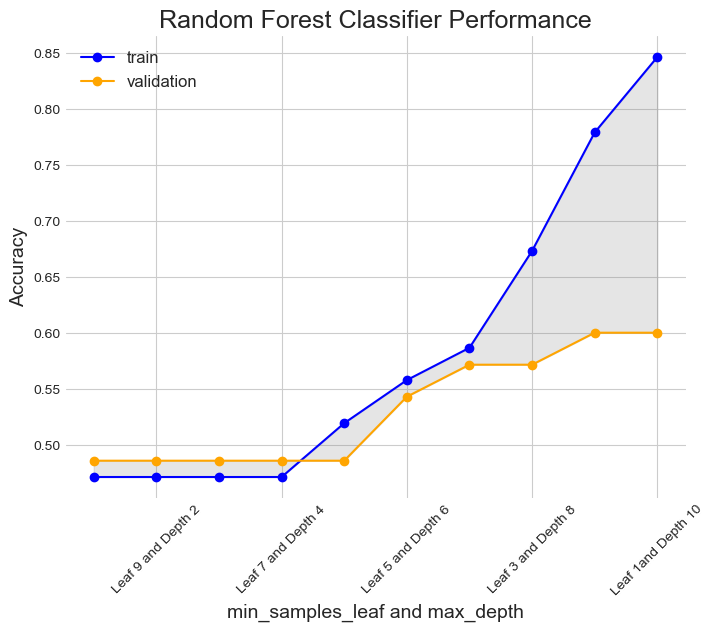

min_samples_leaf  max_depth  train_score  validate_score  diff_score
0                 1         10     0.846154        0.600000    0.246154
1                 2          9     0.778846        0.600000    0.178846
2                 3          8     0.673077        0.571429    0.101648
3                 4          7     0.586538        0.571429    0.015110
4                 5          6     0.557692        0.542857    0.014835
5                 6          5     0.519231        0.485714    0.033516
6                 7          4     0.471154        0.485714   -0.014560
7                 8          3     0.471154        0.485714   -0.014560
8                 9          2     0.471154        0.485714   -0.014560
9                10          1     0.471154        0.485714   -0.014560

In [69]:
# run random forest
random_forest_scores(X_bow, y_train, X_validate_bow, y_validate)

## KNN

In [70]:
def k_nearest(X_bow, y_train, X_validate_bow, y_validate):
    """
    Trains and evaluates KNN models for different values of k and plots the results.

    Parameters:
    -----------
    X_train: array-like, shape (n_samples, n_features)
        Training input samples.
    y_train: array-like, shape (n_samples,)
        Target values for the training input samples.
    X_validate: array-like, shape (n_samples, n_features)
        Validation input samples.
    y_validate: array-like, shape (n_samples,)
        Target values for the validation input samples.

    Returns:
    --------
    results: pandas DataFrame
        Contains the train and validation accuracy for each value of k.
    """
    metrics = []
    train_score = []
    validate_score = []
    for k in range(1,21):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_bow, y_train)
        train_score.append(knn.score(X_bow, y_train))
        validate_score.append(knn.score(X_validate_bow, y_validate))
        diff_score = train_score[-1] - validate_score[-1]
        metrics.append({'k': k, 'train_score': train_score[-1], 'validate_score': validate_score[-1], 'diff_score': diff_score})

    baseline_accuracy = (y_train == 6).mean()

    results = pd.DataFrame.from_records(metrics)

    # modify the last few lines of the function
    # drop the diff_score column before plotting
    results_for_plotting = results.drop(columns=['diff_score'])
    with sns.axes_style('whitegrid'):
        ax = results_for_plotting.set_index('k').plot(figsize=(16,9))
    plt.ylabel('Accuracy')
    plt.axhline(baseline_accuracy, linewidth=2, color='black', label='baseline')
    plt.xticks(np.arange(0,21,1))   
    min_diff_idx = np.abs(results['diff_score']).argmin()
    min_diff_k = results.loc[min_diff_idx, 'k']
    min_diff_score = results.loc[min_diff_idx, 'diff_score']
    #ax.axvline(min_diff_k, linestyle='--', linewidth=2, color='red', label=f'min diff at k={min_diff_k} (diff={min_diff_score:.3f})')
    plt.fill_between(results['k'], train_score, validate_score, alpha=0.2, color='gray', where=(results['k'] > 0))    
    plt.title('K Nearest Neighbor', fontsize=18)
    plt.legend()
    plt.show()
    
    return results

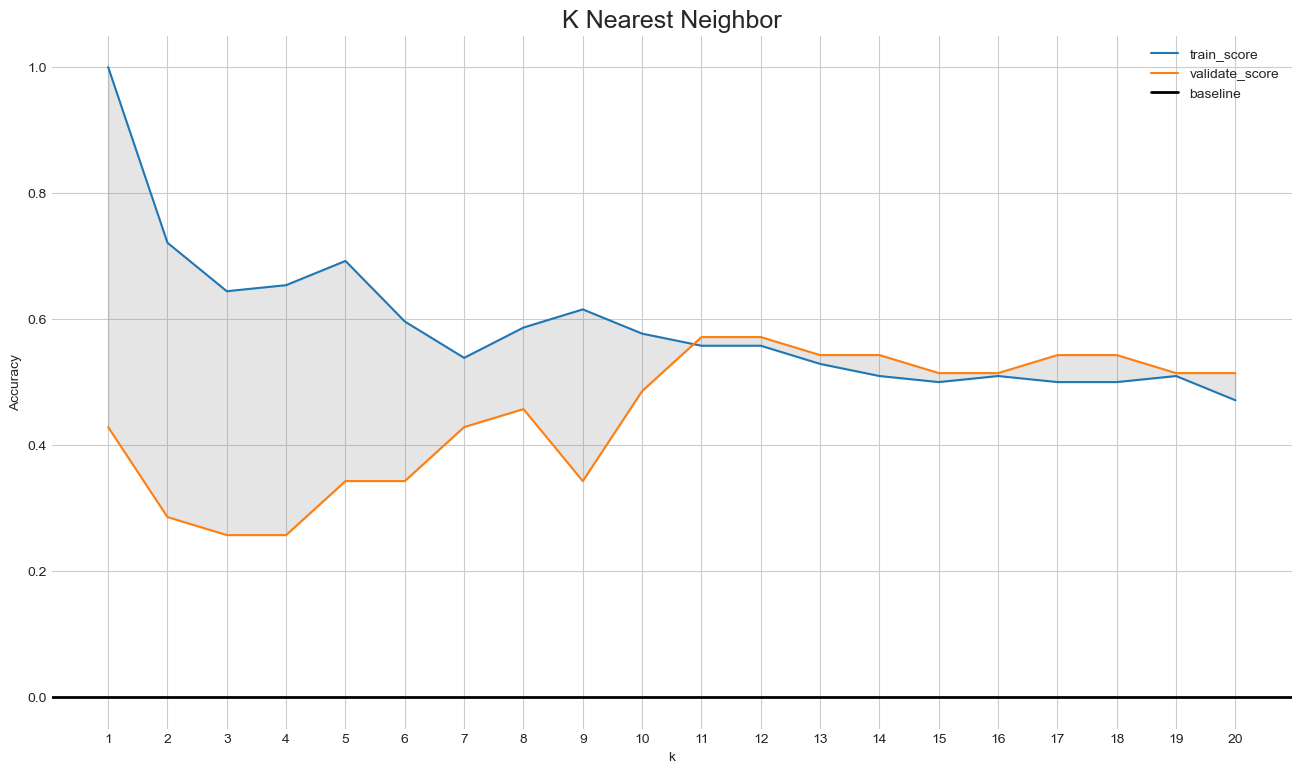

k  train_score  validate_score  diff_score
0    1     1.000000        0.428571    0.571429
1    2     0.721154        0.285714    0.435440
2    3     0.644231        0.257143    0.387088
3    4     0.653846        0.257143    0.396703
4    5     0.692308        0.342857    0.349451
5    6     0.596154        0.342857    0.253297
6    7     0.538462        0.428571    0.109890
7    8     0.586538        0.457143    0.129396
8    9     0.615385        0.342857    0.272527
9   10     0.576923        0.485714    0.091209
10  11     0.557692        0.571429   -0.013736
11  12     0.557692        0.571429   -0.013736
12  13     0.528846        0.542857   -0.014011
13  14     0.509615        0.542857   -0.033242
14  15     0.500000        0.514286   -0.014286
15  16     0.509615        0.514286   -0.004670
16  17     0.500000        0.542857   -0.042857
17  18     0.500000        0.542857   -0.042857
18  19     0.509615        0.514286   -0.004670
19  20     0.471154        0.514286   -0.043132

In [71]:
# run knn
k_nearest(X_bow, y_train, X_validate_bow, y_validate)

## Final Results

# Choose a model
- Based on the following summary:

- Baseline accuracy: 0.472

- Decision Tree (max_depth = 1)
    - train: 0.557692
    - validate: 0.514286
    - difference: 0.043407

- Random Forest (min_samples_leaf = 4, max_depth = 7)
    - train: 0.586538		
    - validate: 0.571429
    - difference: 0.01511

- KNN (k = 13)
    - train: 0.528846		
    - validate: 0.542857
    - difference: -0.014011


All models performed better than baseline. Out of the 3 models, Random Forest performed the best in both the train and validate iterations. Therefore, we chose Random Forest as the model of choice for this project. The test data is ran on the model below:

# Run chosen model on test data

In [72]:
def the_chosen_one(X_bow, X_test_bow, y_train, y_test):
    """
    Trains a LogisticRegression classifier on the provided training data with a pre-selected number of neighbors and 
    evaluates the classifier on the test data.

    Parameters:
    - X_train_scaled (pandas.DataFrame): DataFrame containing the scaled features for the training data.
    - X_test_scaled (pandas.DataFrame): DataFrame containing the scaled features for the test data.
    - y_train (pandas.Series): Series containing the target variable for the training data.
    - y_test (pandas.Series): Series containing the target variable for the test data.

    Returns:
    - test_acc (float): Accuracy score of the trained LogisticRegression classifier on the test data.
    - logit (LogisticRegression): Trained LogisticRegression classifier object.
    """

    rf = RandomForestClassifier(min_samples_leaf= 4, max_depth= 7,random_state=123)
    rf.fit(X_bow, y_train)
    rf.score(X_test_bow, y_test)
        
    return rf.score(X_test_bow, y_test)

In [73]:
# Run test data on chosen model
the_chosen_one(X_bow, X_test_bow, y_train, y_test)

0.5142857142857142

The test model scored 51% which is 4% points better than the baseline!!!